In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import log_loss, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_feather("results/cleaned_df.feather")

In [3]:
df.sample(5)

,CreditScore,GeographyGermany,GeographySpain,GenderMale,Age,Tenure,Balance,NumOfProducts,HasCrCard1,IsActiveMember1,EstimatedSalary,Exited
3919,763.0,0.0,1.0,0.0,39.0,7.0,0.000000,2.0,1.0,0.0,9.876104,0
3982,614.0,0.0,0.0,1.0,46.0,4.0,0.000000,1.0,1.0,0.0,11.216950,1
5297,572.0,1.0,0.0,1.0,51.0,8.0,11.490179,3.0,1.0,1.0,12.170525,1
9225,594.0,1.0,0.0,0.0,32.0,4.0,11.695880,2.0,1.0,1.0,12.001277,0
9083,427.0,0.0,1.0,1.0,40.0,8.0,0.000000,2.0,1.0,1.0,11.325050,0


In [4]:
df.describe()

,CreditScore,GeographyGermany,GeographySpain,GenderMale,Age,Tenure,Balance,NumOfProducts,HasCrCard1,IsActiveMember1,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,650.528800,0.250900,0.247700,0.545700,38.921800,5.012800,7.441327,1.530200,0.70550,0.515100,11.208386
std,96.653299,0.433553,0.431698,0.497932,10.487806,2.892174,5.606400,0.581654,0.45584,0.499797,1.000216
min,350.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,2.532108
25%,584.000000,0.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,10.839642
50%,652.000000,0.000000,0.000000,1.000000,37.000000,5.000000,11.484521,1.000000,1.00000,1.000000,11.514873
75%,718.000000,1.000000,0.000000,1.000000,44.000000,7.000000,11.757010,2.000000,1.00000,1.000000,11.914311
max,850.000000,1.000000,1.000000,1.000000,92.000000,10.000000,12.432806,4.000000,1.00000,1.000000,12.206040


Note that only 20% of the customers have exited. This suggests an unbalanced dataset.

In [5]:
y = df.loc[:, "Exited"]
X = df.drop('Exited', 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

## Exploratory Data Analysis

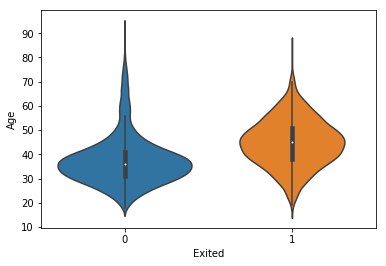

In [7]:
sns.violinplot(x = "Exited", y = "Age", data = df)

The population of exiters (Excited = 1) is older than the population of remainers.

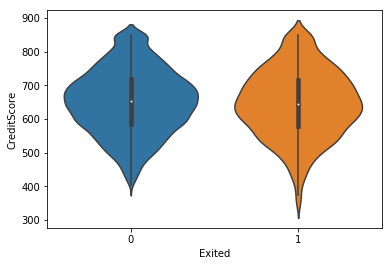

In [8]:
sns.violinplot(x = "Exited", y = "CreditScore", data = df)

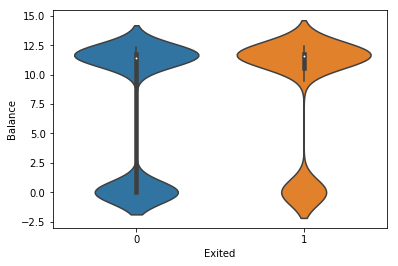

In [9]:
sns.violinplot(x = "Exited", y = "Balance", data = df)

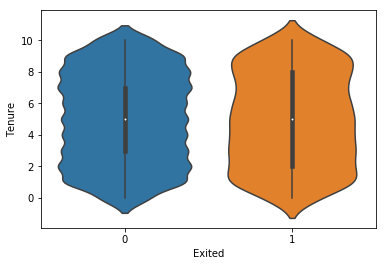

In [10]:
sns.violinplot(x = "Exited", y = "Tenure", data = df)

## Logistic Regression

First, I'm going to determine which coefficients survive an strong L1 weight.

In [22]:
# cv = KFold(n_splits=3, random_state=22)

log_reg = LogisticRegression(penalty='l1', 
                               C=2**-8, 
                               solver='liblinear')
log_reg.fit(X_train, y_train)
y_predict_proba = log_reg.predict_proba(X_test)
y_predict = log_reg.predict(X_test)

In [23]:
log_loss(y_test, y_predict_proba)

0.46308217215016306

In [24]:
accuracy_score(y_test, y_predict)

0.79000000000000004

In [12]:
#TODO Don't forget to score

X_train.columns.values[log_reg.coef_.flatten() == 0]

array(['GeographyGermany', 'GeographySpain', 'GenderMale', 'NumOfProducts',
       'HasCrCard1'], dtype=object)

## Random Forest Feature Importance

In [35]:
random_forest = RandomForestClassifier(max_depth=7)

In [36]:
random_forest.fit(X_train, y_train)
rf_predict_proba = random_forest.predict_proba(X_test)
rf_predict = random_forest.predict(X_test)
log_loss(y_test, rf_predict_proba)

0.35299731435725068

In [37]:
accuracy_score(y_test, rf_predict)

0.85799999999999998

In [39]:
rf_feature_importance = random_forest.feature_importances_

In [42]:
features_ranked = np.argsort(rf_feature_importance)

In [51]:
np.flip(X_train.columns.values[features_ranked], axis = 0)

array(['Age', 'NumOfProducts', 'IsActiveMember1', 'Balance',
       'GeographyGermany', 'CreditScore', 'EstimatedSalary', 'Tenure',
       'GenderMale', 'GeographySpain', 'HasCrCard1'], dtype=object)

In [ ]:
Finding